In [15]:
NOTEBOOK_NAME = "e036_use_associ_add_sml_cd"

In [16]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

In [17]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [18]:
train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [19]:
train = pd.read_parquet(
    "../saved_data/e026_make_data_zakopuro_baseline/train_candidate.parquet"
)

test = pd.read_parquet(
    "../saved_data/e026_make_data_zakopuro_baseline/test_candidate.parquet"
)

In [20]:
train_sml_cd = pd.read_pickle(
    "../saved_data/e031_use_sml_cd/e031_use_sml_cd_train_sml.pkl"
)

test_sml_cd = pd.read_pickle(
    "../saved_data/e031_use_sml_cd/e031_use_sml_cd_test_sml.pkl"
)

In [21]:
train = pd.concat([train, train_sml_cd])
train = train.drop_duplicates(subset=["session_id", "yad_no"]).reset_index(drop=True)

test = pd.concat([test, test_sml_cd])
test = test.drop_duplicates(subset=["session_id", "yad_no"]).reset_index(drop=True)

In [22]:
# reserveを付与する
# 正解ラベルに含まれているレコードの index を配列で取得して
target_index = pd.merge(
    train.reset_index(), train_label, on=["session_id", "yad_no"], how="inner"
)["index"].values

# 正解Indexに含まれている場合 1 / そうでないと 0 のラベルを作成
train["reserve"] = train.index.isin(target_index).astype(int)

In [23]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [24]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [25]:
# # ひとつ前のlogのyad_idの値を取得
# train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
# test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

# Sessionの情報を追加

In [26]:
def add_session_length(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの長さを追加する
    """
    train_session_id_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].count().to_dict()
    )
    test_session_id_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].count().to_dict()
    )

    train["session_length"] = train["session_id"].map(train_session_id_cnt_dict)
    test["session_length"] = test["session_id"].map(test_session_id_cnt_dict)

    return train, test


train, test = add_session_length(train, train_log, test, test_log)

In [27]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [28]:
test

,session_id,yad_no,session_length
0,005ab22bbcba87c59b4a6718fd5709a6,13550,2
1,00a6564cf7ae33af02c9ecfeac0a0b07,635,4
2,00ef7a2cd4ecf01f1921cfff1dc606dc,4913,3
3,0116b42aeb1e24c9d9796b9908879ebe,5415,2
4,012bffe33b46e2c19355af73a6f9dee8,4289,2
...,...,...,...
2522313,ffffe984aafd6127ce8e43e3ca40c79d,7690,1
2522314,ffffe984aafd6127ce8e43e3ca40c79d,6953,1
2522315,ffffe984aafd6127ce8e43e3ca40c79d,7066,1
2522316,ffffe984aafd6127ce8e43e3ca40c79d,8347,1


In [29]:
def add_session_yado_nunique(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの中で登場したyadoの数を追加する
    """
    train_session_yado_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )
    test_session_yado_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )

    train["session_yado_nunique"] = train["session_id"].map(train_session_yado_cnt_dict)
    test["session_yado_nunique"] = test["session_id"].map(test_session_yado_cnt_dict)

    return train, test


train, test = add_session_yado_nunique(train, train_log, test, test_log)

In [30]:
def add_session_yado_cnt(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionとyadごとに、yad_noが登場した回数を数える
    """
    train = train.copy()
    train_log = train_log.copy()
    test = test.copy()
    test_log = test_log.copy()

    train_session_yado_cnt = (
        train_log.groupby(["session_id", "yad_no"])["yad_no"]
        .count()
        .rename("session_yado_cnt")
    )
    test_session_yado_cnt = (
        test_log.groupby(["session_id", "yad_no"])["yad_no"]
        .count()
        .rename("session_yado_cnt")
    )

    train = train.merge(train_session_yado_cnt, on=["session_id", "yad_no"], how="left")
    train["session_yado_cnt"] = train["session_yado_cnt"].fillna(0).astype(int)

    test = test.merge(test_session_yado_cnt, on=["session_id", "yad_no"], how="left")
    test["session_yado_cnt"] = test["session_yado_cnt"].fillna(0).astype(int)

    return train, test


train, test = add_session_yado_cnt(train, train_log, test, test_log)

# logの中で、宿の情報の統計値（平均、最大、最小、分散、中央値）をとる

In [31]:
def add_yad_statistic_from_log(
    log_df: pd.DataFrame, session_df: pd.DataFrame, yado: pd.DataFrame
):
    log_df = log_df.copy()
    session_df = session_df.copy()
    yado = yado.copy()

    log_with_yad = pd.merge(log_df, yado, on="yad_no", how="left")

    use_cols = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]

    agg_ways = ["mean", "max", "min", "std", "median"]

    for yad_col in use_cols:
        agg_df = (
            log_with_yad.groupby("session_id")[yad_col]
            .agg(agg_ways)
            .add_prefix(f"{yad_col}_")
        )
        session_df = pd.merge(session_df, agg_df, on="session_id", how="left")

    agg_col_name = [
        f"{yad_col}_{agg_way}" for yad_col in use_cols for agg_way in agg_ways
    ]

    return session_df, agg_col_name


train, yado_agg_col = add_yad_statistic_from_log(train_log, train, yado)
test, _ = add_yad_statistic_from_log(test_log, test, yado)

# logの中で、wid_cd、ken_cd、lrg_cd、sml_cdのnuniqueをとる

In [32]:
def add_yad_area_nunique_from_log(
    log_df: pd.DataFrame, session_df: pd.DataFrame, yado: pd.DataFrame
):
    log_df = log_df.copy()
    session_df = session_df.copy()
    yado = yado.copy()

    log_with_yad = pd.merge(log_df, yado, on="yad_no", how="left")

    use_cols = ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]

    for area_col in use_cols:
        agg_df = (
            log_with_yad.groupby("session_id")[area_col]
            .nunique()
            .rename(f"{area_col}_nunique")
        )
        session_df = session_df.merge(agg_df, on="session_id", how="left")

    out_cols = [f"{area_col}_nunique" for area_col in use_cols]

    return session_df, out_cols


train, yad_area_nunique = add_yad_area_nunique_from_log(train_log, train, yado)
test, _ = add_yad_area_nunique_from_log(train_log, test, yado)

# session lengthが2以上の場合は、該当の宿がreverse_seq_no(max_seq_no - seq_no)を追加し、reverse_seq_noが偶数か奇数かのフラグを立てる

In [33]:
def add_reverse_seq_no(log_df: pd.DataFrame, session_df: pd.DataFrame):
    log_df = log_df.copy()
    session_df = session_df.copy()

    # session_dfにseq_noを結合する
    log_df_no_dup = log_df.drop_duplicates(subset=["session_id", "yad_no"], keep="last")
    session_df = session_df.merge(
        log_df_no_dup, on=["session_id", "yad_no"], how="left"
    )

    # sessionごとに最大のseq_noを結合する
    log_max_seq_no = log_df.groupby("session_id")["seq_no"].max()
    log_max_seq_no.name = "max_seq_no"
    session_df = session_df.merge(log_max_seq_no, on="session_id", how="left")

    # sessionの最大のseq_noの差分を取る(そのセッションが最後から何番目か？)
    session_df["reverse_seq_no"] = session_df["max_seq_no"] - session_df["seq_no"]
    session_df["is_reverse_seq_no_odd"] = session_df["reverse_seq_no"] % 2

    session_df.drop(columns=["seq_no", "max_seq_no"], inplace=True)

    return session_df


train = add_reverse_seq_no(log_df=train_log, session_df=train)
test = add_reverse_seq_no(log_df=test_log, session_df=test)
# TODO: ここの処理が正しいか確認する
# -> OK

In [34]:
reverse_seq_feat = ["reverse_seq_no", "is_reverse_seq_no_odd"]

# 正解のyadoと1つ前のyadoの情報の追加

In [35]:
# 一番直近に見たyad_noを追加
train_previous_1_yad_no_dict = (
    train_log.groupby("session_id")["yad_no"].apply(lambda x: list(x)[-1]).to_dict()
)
test_previous_1_yad_no_dict = (
    test_log.groupby("session_id")["yad_no"].apply(lambda x: list(x)[-1]).to_dict()
)

train["previous_1_yad_no"] = train["session_id"].map(train_previous_1_yad_no_dict)
test["previous_1_yad_no"] = test["session_id"].map(test_previous_1_yad_no_dict)

In [36]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [37]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

# 今の部屋と、前の部屋のwid_cd、ken_cd、lrg_cd、sml_cdが一緒かどうか

In [38]:
train["same_wid_cd_now_previous_1"] = train["now_wid_cd"] == train["previous_1_wid_cd"]
train["same_ken_cd_now_previous_1"] = train["now_ken_cd"] == train["previous_1_ken_cd"]
train["same_lrg_cd_now_previous_1"] = train["now_lrg_cd"] == train["previous_1_lrg_cd"]
train["same_sml_cd_now_previous_1"] = train["now_sml_cd"] == train["previous_1_sml_cd"]

test["same_wid_cd_now_previous_1"] = test["now_wid_cd"] == test["previous_1_wid_cd"]
test["same_ken_cd_now_previous_1"] = test["now_ken_cd"] == test["previous_1_ken_cd"]
test["same_lrg_cd_now_previous_1"] = test["now_lrg_cd"] == test["previous_1_lrg_cd"]
test["same_sml_cd_now_previous_1"] = test["now_sml_cd"] == test["previous_1_sml_cd"]

same_area_feat = [
    "same_wid_cd_now_previous_1",
    "same_ken_cd_now_previous_1",
    "same_lrg_cd_now_previous_1",
    "same_sml_cd_now_previous_1",
]

# foldごとに、rulebaseで推論した結果をrulebeased_predict_yadoとして追加する

In [39]:
train_predicted_df = pd.read_pickle(
    "../saved_data/e024_make_rulebased_feat/all_rulebased_predict_df_train.pkl"
)

test_predicted_df = pd.read_pickle(
    "../saved_data/e024_make_rulebased_feat/all_rulebased_predict_df_test.pkl"
)

In [40]:
train = pd.merge(train, train_predicted_df, on="session_id", how="left")
test = pd.merge(test, test_predicted_df, on="session_id", how="left")

In [41]:
rulebased_predict_feat = [
    "rulebased_predict_0",
    "rulebased_predict_1",
    "rulebased_predict_2",
    "rulebased_predict_3",
    "rulebased_predict_4",
    "rulebased_predict_5",
    "rulebased_predict_6",
    "rulebased_predict_7",
    "rulebased_predict_8",
    "rulebased_predict_9",
]

In [42]:
for i in range(10):
    train[f"same_rulebased_predict_{i}"] = (
        train["yad_no"] == train[f"rulebased_predict_{i}"]
    )
    test[f"same_rulebased_predict_{i}"] = (
        test["yad_no"] == test[f"rulebased_predict_{i}"]
    )

In [43]:
same_rulebased_predict_feat = [f"same_rulebased_predict_{i}" for i in range(10)]

# データ型の変更

In [44]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    "wid_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "ken_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "lrg_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
previous_1_yado_categorical_cols = [
    f"previous_1_{col}" for col in base_categorical_cols
]

categorical_cols = (
    now_yado_categorical_cols
    + previous_1_yado_categorical_cols
    + rulebased_predict_feat
)

In [45]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [46]:
# # Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
# FOLD_NUM = 5

# # skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# # for fold, (_, v_idx) in enumerate(
# #     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# # ):
# #     train.loc[v_idx, "fold"] = fold

# # TODO: yをsession_lengthにして試してみる
# # sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
# # for fold, (_, v_idx) in enumerate(
# #     sgkf.split(
# #         X=train,
# #         y=train["reserve"],
# #         groups=train["session_id"],
# #     )
# # ):
# #     train.loc[v_idx, "fold"] = fold

# gkf = GroupKFold(n_splits=FOLD_NUM)
# for fold, (_, v_idx) in enumerate(
#     gkf.split(
#         X=train,
#         groups=train["session_id"],
#     )
# ):
#     train.loc[v_idx, "fold"] = fold

# train["fold"] = train["fold"].astype(int)

In [47]:
# e016にて、データ作成時にfoldを利用するように変更
with open(
    "../saved_data/e016_make_train_popular_base/session_id_fold_dict.pkl", "rb"
) as f:
    session_id_fold_dict = pickle.load(f)

train["fold"] = train["session_id"].map(session_id_fold_dict)

In [48]:
FOLD_NUM = 5

In [49]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.961187
      1          0.038813
1     0          0.960983
      1          0.039017
2     0          0.960868
      1          0.039132
3     0          0.961106
      1          0.038894
4     0          0.961148
      1          0.038852
Name: proportion, dtype: float64

# 人気の宿情報、つまり予約された回数をfoldごとに付与する

In [50]:
session_id_fold_df = train[["session_id", "fold"]].drop_duplicates()
session_id_fold_dict = dict(
    zip(session_id_fold_df["session_id"], session_id_fold_df["fold"])
)

In [51]:
def add_popular_per_fold(
    train: pd.DataFrame,
    train_label: pd.DataFrame,
    test: pd.DataFrame,
    n_fold: int = FOLD_NUM,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    foldごとに、宿が予約された回数を計算する
    NOTE: 人気情報を付与して0.42ぐらいかなかったら何か間違っていそう
    """
    train_label_copy = train_label.copy()

    # train_labelに対して、trainを用いてsession_idごとのfoldを付与
    session_id_fold_df = train[["session_id", "fold"]].drop_duplicates()
    session_id_fold_dict = dict(
        zip(session_id_fold_df["session_id"], session_id_fold_df["fold"])
    )

    # その後、train_labelを用いて、foldごとにreserveの合計を計算
    train_label_copy["fold"] = train_label_copy["session_id"].map(session_id_fold_dict)

    # 学習データへの人気宿情報の付与
    for fold in range(n_fold):
        train_out_of_fold_df = train_label_copy[train_label_copy["fold"] != fold]

        train_yad_no_cnt_per_fold_dict = (
            train_out_of_fold_df.groupby("yad_no")["yad_no"].count()
            / train_out_of_fold_df.shape[0]
        ).to_dict()
        train.loc[train["fold"] == fold, "popular_yado_rate_per_fold"] = train.loc[
            train["fold"] == fold, "yad_no"
        ].map(train_yad_no_cnt_per_fold_dict)

    # テストデータへの人気宿情報の付与
    test_yad_no_cnt_per_fold_dict = (
        train_label_copy.groupby("yad_no")["yad_no"].count() / train_label_copy.shape[0]
    ).to_dict()
    test["popular_yado_rate_per_fold"] = test["yad_no"].map(
        test_yad_no_cnt_per_fold_dict
    )

    # 学習・テスト共に、1度も登場しなかった宿は予約回数が0回となるため、0に置換
    train["popular_yado_rate_per_fold"] = train["popular_yado_rate_per_fold"].fillna(0)
    test["popular_yado_rate_per_fold"] = test["popular_yado_rate_per_fold"].fillna(0)

    return train, test


train, test = add_popular_per_fold(train, train_label, test)

# 共起の情報を追加する

In [52]:
kyouki_df_train = pd.read_pickle(
    f"../saved_data/e033_make_feat_kyouki/kyouki_df_train.pkl"
)
kyouki_df_test = pd.read_pickle(
    f"../saved_data/e033_make_feat_kyouki/kyouki_df_test.pkl"
)

In [53]:
train = train.merge(
    kyouki_df_train,
    left_on=["fold", "previous_1_yad_no"],
    right_on=["fold", "latest_yad_no"],
    how="left",
)

test = test.merge(
    kyouki_df_test,
    left_on="previous_1_yad_no",
    right_on="latest_yad_no",
    how="left",
)

In [54]:
kyouki_feat = [f"kyouki_arr_reduced_{col}" for col in range(100)]

# アソシエーションルールを追加

In [55]:
train_co_visit_matrix = pd.read_parquet(
    f"../saved_data/e035_make_associ/train_co_visit_matrix.pkl"
)
test_co_visit_matrix = pd.read_parquet(
    f"../saved_data/e035_make_associ/test_co_visit_matrix.pkl"
)

In [56]:
train_co_visit_matrix.rename(
    columns={"latest_yad_no": "previous_1_yad_no"}, inplace=True
)
test_co_visit_matrix.rename(
    columns={"latest_yad_no": "previous_1_yad_no"}, inplace=True
)

In [57]:
train = train.merge(
    train_co_visit_matrix,
    on=["previous_1_yad_no", "yad_no"],
    how="left",
)

test = test.merge(
    test_co_visit_matrix,
    on=["previous_1_yad_no", "yad_no"],
    how="left",
)

In [58]:
associ_feat = ["co_visit_count"]

# 保存

In [59]:
# 学習とテストに使うデータを保存する
train.to_pickle(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_train.pkl")

test.to_pickle(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_test.pkl")

# LightGBM

In [60]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

# session系の特徴量
session_numeric_col = [
    "session_length",
    "session_yado_nunique",
    "session_yado_cnt",
]

per_fold_col = ["popular_yado_rate_per_fold"]

numeric_cols = (
    now_yado_numeric_col
    + previous_1_yado_numeric_col
    + session_numeric_col
    + per_fold_col
    + same_area_feat  # 同じエリアかどうか
    + yado_agg_col  # yadoの統計量
    + yad_area_nunique  # areaの統計量
    + reverse_seq_feat  # 逆順の特徴量
    + kyouki_feat  # 共起特徴量
    + associ_feat  # アソシエーションルールの特徴量
)

In [61]:
use_col = numeric_cols + categorical_cols
len(use_col)

191

In [62]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": -1,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [63]:
# params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します.
#     "objective": "binary",
#     # 木の最大数
#     "n_estimators": 10000,
#     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     # 今回設定している 0.3 は比較的大きめの設定です
#     "learning_rate": 0.3,
#     # 特徴重要度計算のロジック(後述)
#     "importance_type": "gain",
#     "random_state": 510,
# }

In [64]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [65]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=2000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0873871	valid_1's binary_logloss: 0.0889974
[200]	training's binary_logloss: 0.0853162	valid_1's binary_logloss: 0.0888012
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0861201	valid_1's binary_logloss: 0.0887646
fold 0 Score: 0.8975837044308801
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0872298	valid_1's binary_logloss: 0.0896439
[200]	training's binary_logloss: 0.0852841	valid_1's binary_logloss: 0.0895
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0859891	valid_1's binary_logloss: 0.0894723
fold 1 Score: 0.8972487345555922
Start fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0871138	valid_1's binary_logloss: 0.0901824
[200]	training's binary_logloss: 0.0851128	valid_1's binary_logloss: 0.0900011
[300]	trai

In [66]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

In [67]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "rb") as f:
    models = pickle.load(f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "rb") as f:
    oof = pickle.load(f)

In [68]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.8970361727703736

In [69]:
train["oof_pred"] = oof

In [70]:
# trainをoofが0でないものだけに絞る
def get_oof_pred_df(train: pd.DataFrame, oof: np.ndarray) -> pd.DataFrame:
    train_for_calc_mapk = train.copy()
    train_for_calc_mapk["oof"] = oof
    train_for_calc_mapk = train_for_calc_mapk[train_for_calc_mapk["oof"] != 0]

    # 推論順にsession_idとyad_noを並べる
    oof_pred_yad = (
        train_for_calc_mapk.sort_values(["session_id", "oof"], ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    ).to_dict()

    # train_labelをoofの計算用に用意
    train_label_for_calc_oof = train_label.copy()

    # train_for_calc_mapkに付与
    train_label_for_calc_oof["pred_yad_no_list"] = train_label_for_calc_oof[
        "session_id"
    ].map(oof_pred_yad)

    # oofが計算されていないsession_idは削除
    train_label_for_calc_oof = train_label_for_calc_oof[
        train_label_for_calc_oof["pred_yad_no_list"].notnull()
    ].reset_index(drop=True)

    # 上位10件に限定
    train_label_for_calc_oof["pred_yad_no_list_top10"] = train_label_for_calc_oof[
        "pred_yad_no_list"
    ].apply(lambda x: x[:10])

    # listをpd.Seriesに変換
    oof_pred_df = train_label_for_calc_oof.set_index("session_id")[
        "pred_yad_no_list_top10"
    ].apply(pd.Series)
    oof_pred_df = oof_pred_df.rename(columns=lambda x: "predict_" + str(x))

    # Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
    # TODO: 埋めるのは0で本当に良いのか考える
    oof_pred_df = oof_pred_df.fillna(0).astype(int)

    return oof_pred_df


oof_pred_df = get_oof_pred_df(train, oof)

In [71]:
oof_pred_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,11882,2808,5289,5821,12837,997,7157,11134,12846,8927
0000ca043ed437a1472c9d1d154eb49b,8140,6602,1092,13717,825,8677,8253,13210,3564,11104
0000d4835cf113316fe447e2f80ba1c8,9039,5238,918,6722,7796,7509,13642,2957,12033,6676
0000fcda1ae1b2f431e55a7075d1f500,755,11715,1341,109,6178,10483,8355,626,9438,13549
000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,11380,902,5490,10905,12338,1908,12491
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,8677,1092,6602,13210,13717,825,3184,3237,3564,8845
ffff2360540745117193ecadcdc06538,8703,4767,5299,3940,399,8465,513,6654,2900,8524
ffff7fb4617164b2604aaf51c40bf82d,12240,2087,4398,7308,11850,9558,4040,7820,6630,7057


In [72]:
train_label[train_label["session_id"].isin(oof_pred_df.index)]

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [73]:
session_id = "0000ca043ed437a1472c9d1d154eb49b"
train_log[train_log["session_id"] == session_id]

,session_id,seq_no,yad_no
1,0000ca043ed437a1472c9d1d154eb49b,0,13535


In [74]:
train[train["session_id"] == session_id].to_csv("aa.csv", index=False)

In [75]:
train[(train["previous_1_yad_no"] == 13535) & (train["reserve"] == 1)]

,session_id,yad_no,reserve,session_length,session_yado_nunique,session_yado_cnt,yad_type_mean,yad_type_max,yad_type_min,yad_type_std,...,kyouki_arr_reduced_92,kyouki_arr_reduced_93,kyouki_arr_reduced_94,kyouki_arr_reduced_95,kyouki_arr_reduced_96,kyouki_arr_reduced_97,kyouki_arr_reduced_98,kyouki_arr_reduced_99,co_visit_count,oof_pred
78835,0000ca043ed437a1472c9d1d154eb49b,8253,1,1,1,0,0.0,0,0,NaN,...,-0.018321,0.048106,-0.079223,0.017174,-0.026515,-0.005653,-0.038796,-0.016006,16.0,0.012922
1015743,7ac9001b69794a36ca365b3f44ca5b93,8253,1,3,2,1,0.0,0,0,0.0,...,0.026625,0.000701,-0.042324,-0.045806,-0.075861,-0.071009,-0.135337,0.062751,16.0,0.911687
1364609,d5b30b9921aaa93d89218c69fc4d5e06,8253,1,2,2,1,0.0,0,0,0.0,...,-0.047564,0.001171,-0.026591,0.014134,0.022588,-0.049568,-0.077162,0.064934,16.0,0.441699
1697743,dc15f1fb346c6b5bc594eea4e28d8be5,4488,1,2,2,1,0.0,0,0,0.0,...,-0.047564,0.001171,-0.026591,0.014134,0.022588,-0.049568,-0.077162,0.064934,1.0,0.969518
1698464,36deecb8d5c3f272b9165af2e7523b50,11104,1,2,2,1,0.0,0,0,0.0,...,0.009005,0.009858,0.024274,0.041649,-0.031017,-0.053278,0.062472,0.054897,1.0,0.964038
2301525,a06bbaa365e2e3e464af5ebce3480f6d,11104,1,1,1,0,0.0,0,0,NaN,...,0.027248,0.032214,-0.003201,0.030587,-0.015495,0.040778,0.011735,0.033990,1.0,0.007950
3318603,5f14b43b8e086d726305ce0e73a0d2d1,3564,1,1,1,0,0.0,0,0,NaN,...,0.009005,0.009858,0.024274,0.041649,-0.031017,-0.053278,0.062472,0.054897,NaN,0.013612
4138484,ddd4f6a3f0dadaf4987c5e1b374fc49c,1092,1,1,1,0,0.0,0,0,NaN,...,-0.047564,0.001171,-0.026591,0.014134,0.022588,-0.049568,-0.077162,0.064934,NaN,0.020542


In [76]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [77]:
# MAPK (k=10) として計算
sorted_train_label = (
    train_label[train_label["session_id"].isin(oof_pred_df.index)]
    .sort_values("session_id")["yad_no"]
    .values
)

assert len(sorted_train_label) == len(oof_pred_df)

oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_pred_df.sort_index().values.tolist(),
    k=10,
)
oof_mapk_score

0.3892597754427276

In [78]:
feature_importance_df = pd.DataFrame()

for fold, model in enumerate(models):
    _df = pd.DataFrame()
    _df[f"fold_{fold}"] = model.feature_importance(importance_type="gain")
    _df = _df.T
    _df.columns = use_col
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0)
order = _df.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots(figsize=(max(6, len(order) * 0.4), len(order) * 0.5))
sns.boxplot(
    data=feature_importance_df, orient="h", order=order, ax=ax, palette="viridis"
)
ax.grid()
fig.tight_layout()

# Testに対する推論

In [79]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

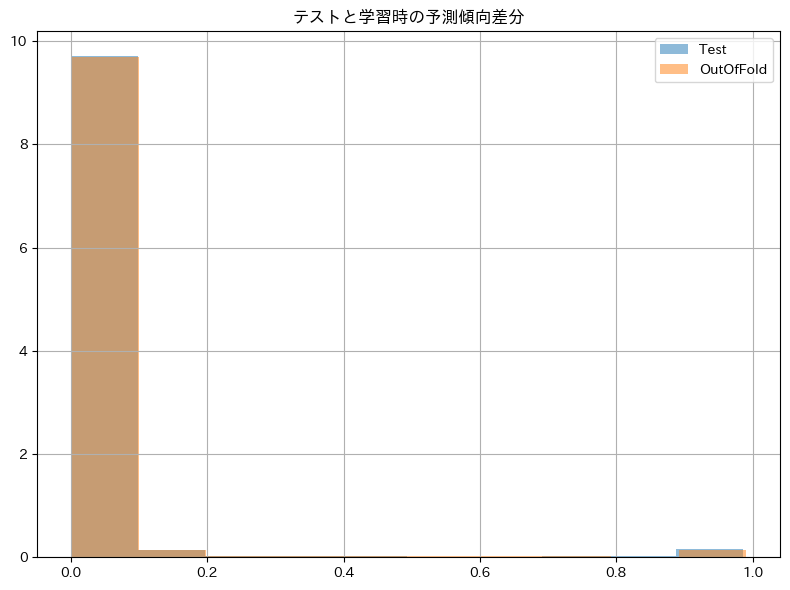

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [81]:
test["pred"] = pred

In [82]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [83]:
# TOP10に並び替え
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

# test_sessionのpred_yad_no_listがNaNの場合は、[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]で埋める
test_session["pred_yad_no_list"] = test_session["pred_yad_no_list"].apply(
    lambda x: x if isinstance(x, list) else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
)

# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

print(pred_yad_df.isnull().sum())

# Nullの箇所はyad_no=10095(一番人気)で保管し、全ての値をintに変換する
# NOTE: 保管するのは本当に10095で良いのか考える
pred_yad_df = pred_yad_df.fillna(10095).astype(int)

predict_0      0
predict_1      0
predict_2      0
predict_3      0
predict_4     10
predict_5     86
predict_6    296
predict_7    425
predict_8    510
predict_9    607
dtype: int64


In [84]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [85]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)

In [86]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,4420,2680,5466,10233,11561,9534,4714,9830,10965
1,4066,143,12862,1266,5267,7014,8108,11237,6129,6555
2,757,9190,7710,9910,1774,6721,410,10485,2267,6730
3,12341,3359,6991,13521,5657,10861,4180,10746,277,2047
4,5713,6576,12524,13590,9020,5106,6703,3187,11442,101
...,...,...,...,...,...,...,...,...,...,...
174695,1997,5744,7888,7062,9743,10997,2278,7780,11123,1885
174696,12432,6874,4014,1227,3802,2232,5331,9723,3644,2164
174697,10155,7379,12986,12425,12132,8468,11037,12089,6199,8143
174698,3100,11496,2305,10287,6378,2373,5513,2692,8501,1530


In [87]:
f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv"

'../sub/e036_use_associ_add_sml_cd_auc0.8970_mapk0.3893.csv'

In [88]:
# TODO: 人気の情報を入れて、CVが改善しているのにtestのスコアが改善しないのはおかしいため、原因を調べる